### set libraly

In [1]:
import pandas as pd
import os
import numpy as np
import glob
import codecs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


In [2]:
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style
pd.set_option('display.max_rows', 5000)

### set path

In [4]:
input = "Input\\"
input_data = "Input\\data\\"
input_mapping = "Input\\mapping\\"
output = "Output\\"
dataprepare = "dataprepare\\"
#os.mkdir(input)
#os.mkdir(output)
#os.mkdir(input_data)
#os.mkdir(input_mapping)
#os.mkdir(dataprepare)

### prepare data

In [3]:
class RawData:
      def __init__(self, folder, folder2):
    
        self.folder = folder
        self.file = glob.glob(folder+"/*.csv")[-1]
        self.folder2 = folder2
        self.file2 = glob.glob(folder+"/*.xlsb")[-1]

    
        print(f"Start to read CSV file '{self.file[-26:]}' in folder '{self.folder}'")
        self.df = pd.read_csv(self.file,encoding='UTF-8' )
        print(f"Read CSV file '{self.file[-22:]}' done!","\n")
        
      def remove_white_space(self):
            print("Start remove_white_space function")
            for col in self.df.columns.tolist():
              if self.df[col].dtypes == object:
                self.df[col] = self.df[col].str.strip()
              print("Remove_white_space done!","\n")
      def save_csv(self):
              self.df.to_csv(input_data+"test.csv",encoding='TIS-620')
              print(f"save file {self.file[-22:]} done" , "\n")

      #def mapping_data(self):
       #       self.df_mapping = pd.read_excel(self.file2,encoding='UTF-8' )
              
    #self.file[-22:]

In [5]:
test = RawData(input_data)
test.remove_white_space()

Start to read CSV file 'Input\data\CRR2563.csv' in folder 'Input\data\'
Read CSV file 'Input\data\CRR2563.csv' done! 

Start remove_white_space function
Remove_white_space done! 

Remove_white_space done! 

Remove_white_space done! 

Remove_white_space done! 

Remove_white_space done! 

Remove_white_space done! 



## manual

In [5]:
mapping = pd.read_excel(input_mapping+'RPISIC01_20211231_ข้อมูลรายตัวสำหรับตรวจสอบ (22 ประเภทธุรกิจ).xlsb',engine='pyxlsb',usecols=['Customer Number','Account Number','USER2','Account Class','PF/NPF Flag'] )

In [6]:
### prepare
data = pd.read_csv(input_data+'CRR2563.csv',encoding='UTF-8')
data['เลขที่ CIF'] = data['เลขที่ CIF'].str.strip()
data.dropna(subset=['เลขที่ CIF'],inplace=True)
data.rename(columns={"เลขที่ CIF": "Customer Number"},inplace=True)

In [7]:
### fitter not number
data_main = data[data['Customer Number'].str.contains(r'[0-9]')]
### convert type object to int
data_main['Customer Number'] = data_main['Customer Number'].astype(np.int64)

<ipython-input-7-0c8610853727>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_main['Customer Number'] = data_main['Customer Number'].astype(np.int64)


In [8]:
df = data_main.merge(mapping,on='Customer Number',how='left')

In [9]:
df['USER2'].isnull().value_counts()

False    3026
True      379
Name: USER2, dtype: int64

In [ ]:
df = df.dropna(subset=['USER2'])
df = df.drop_duplicates(subset=['Customer Number'])
df = df.dropna(subset=['Grade'])
df = df[~(df['Grade']=='-')]
df.reset_index(drop=True)

### Define Good_Bad

In [11]:
def define_Good_Bad(df):
    condition = [(df['USER2'] == 'B1')|(df['USER2'] == 'B2'),(df['USER2'] == 'B2')|(df['USER2'] == 'B4')|(df['USER2'] == 'B5')]
    mapping_Good = (1,0)
    mapping_Bad = (0,1)
    df['Good'] = np.select(condition, mapping_Good)
    df['Bad'] = np.select(condition, mapping_Bad)
    
define_Good_Bad(df)

In [41]:
#df.drop(columns=['bad'],inplace=True)

### Medium && Large CRR

In [44]:
df['Grade'].isna().value_counts()
df.groupby(['Grade']).count()
df_CRR = df[~df['Grade'].str.contains('[s,S]')]
df_CRR[['Grade','Good','Bad']].groupby(['Grade']).sum()

,Good,Bad
Grade,,
A+,5,1
B+,29,0
BB,22,0
BBB,22,0
C+,28,0
CC,16,0
CCC,17,1
D+,1,0
DD,1,0


### Small CRR

In [45]:
df_sCRR = df[df['Grade'].str.contains('[s,S]')]
df_sCRR.loc[df_sCRR['Grade']=='SBB','Grade'] = 'sBB'
df_sCRR.loc[df_sCRR['Grade']=='sc+','Grade'] = 'sC+'
df_sCRR = df_sCRR[~(df_sCRR['Grade']=='SS')]
df_sCRR[['Grade','Good','Bad']].groupby(['Grade']).sum()

c:\Users\630039\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Good,Bad
Grade,,
sA+,30,0
sAA,1,0
sB+,130,1
sBB,175,1
sBBB,125,0
sC+,20,4
sCC,43,3
sCCC,88,6
sDD,2,0


In [410]:
table = df_CRR[['Grade','Good','Bad']].groupby(['Grade']).sum()
table.reset_index(inplace=True)
table.sort_index(ascending=True,inplace=True)

## KS index

In [62]:
def KS_index(df):
  
  table = df[['Grade','Good','Bad']].groupby(['Grade']).sum()
  table.reset_index(inplace=True)
  table.sort_index(ascending=False,inplace=True)
  table['N'] = table['Good'] + table['Bad']
  table['badRate'] = table['Bad'] / table['N']
  table['goodRate'] = table['Good'] / table['N']
  table['%Bad'] = table['Bad'] / table['Bad'].sum()
  table['%Good'] = table['Good'] / table['Good'].sum()
  table['cumBadFreq'] = table['%Bad'].cumsum()
  table['cumGoodFreq'] = table['%Good'].cumsum()
  table['BGOdds'] = table['Bad'].cumsum() / table['Good'].cumsum()
  table['GBOdds'] = table['Good'].cumsum() / table['Bad'].cumsum()
  table['cumBad'] = table['Bad'].cumsum() / table['Bad'].sum()
  table['cumGood'] = table['Good'].cumsum() / table['Good'].sum()
  table['ROC'] = (table['cumGood'] - table['cumGood'].shift(1, fill_value = 0)) * \
                 (table['cumBad'] + table['cumBad'].shift(1, fill_value = 0)) * 0.5
  table['KS'] = abs(table['cumGood'] - table['cumBad']) 
  return table

def plot_KS(df):
  
  KS = df['KS'].max()
  plt.figure(figsize = (10, 6))
  plt.plot(
    np.hstack((0, df['cumGood'])),
    c = 'forestgreen',
    label = 'Cumulative good'
  )
  plt.plot(
    np.hstack((0, df['cumBad'])),
    c = 'gray',
    label = 'Cumulative bad'
    )
  plt.plot([], [], ' ', label = f'KS: {KS * 100:.2f}%')
  plt.xticks(
    np.arange(1, df.shape[0] + 1),
    df['Grade']
  )
  # Fotmat axis label
  ks_max_idx = df['KS'].idxmax()
  ks_N_idx = df.index.max()

  plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
  plt.title('KS Curve')
  plt.xlabel('Score bands')
  plt.ylabel('Percentage of cumulative')
  plt.legend(frameon = True, facecolor = 'white')
  plt.vlines(ks_N_idx-ks_max_idx+1, ymin = df['cumBad'][ks_max_idx],
             ymax = df['cumGood'][ks_max_idx], color="k", linestyles="--")
  return plt.show()


<ipython-input-62-09b93aab75c5>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])


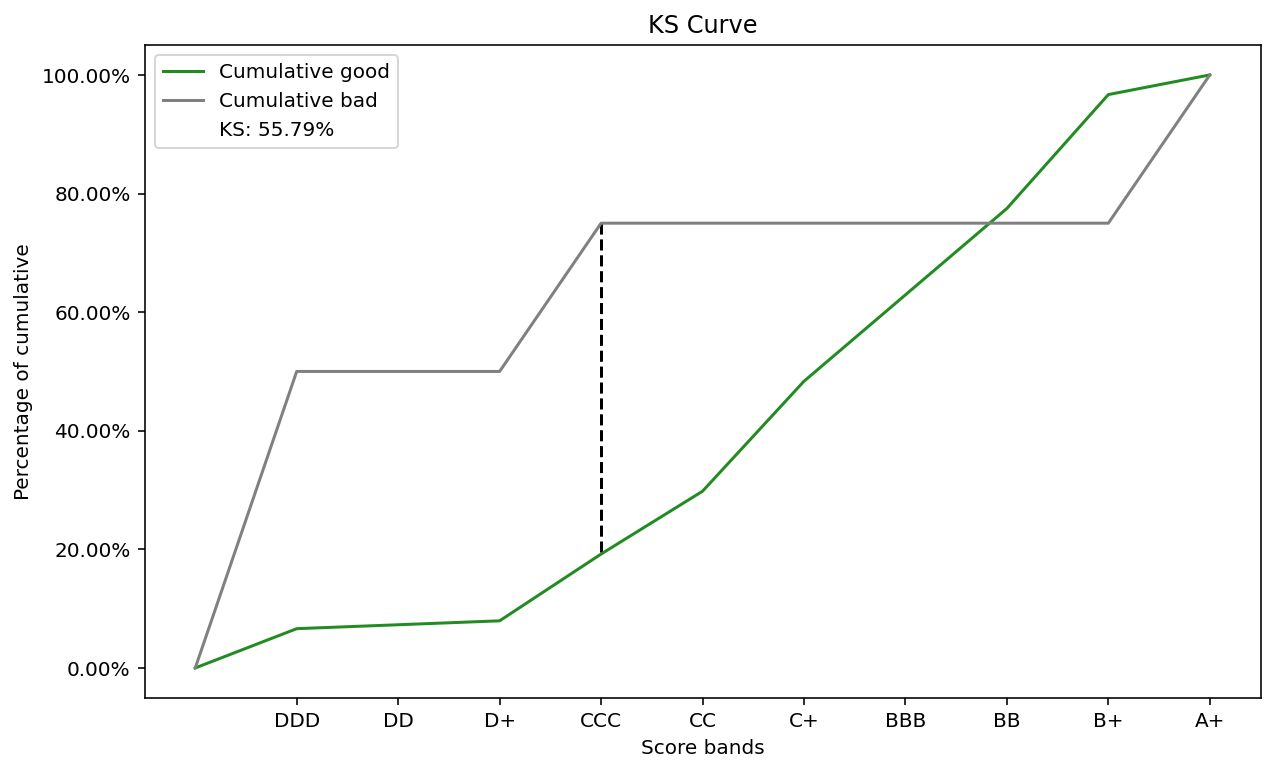

In [63]:
CRR = KS_index(df_CRR)
plot_KS(CRR)

#sCRR = KS_index(df_sCRR)

<ipython-input-62-09b93aab75c5>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])


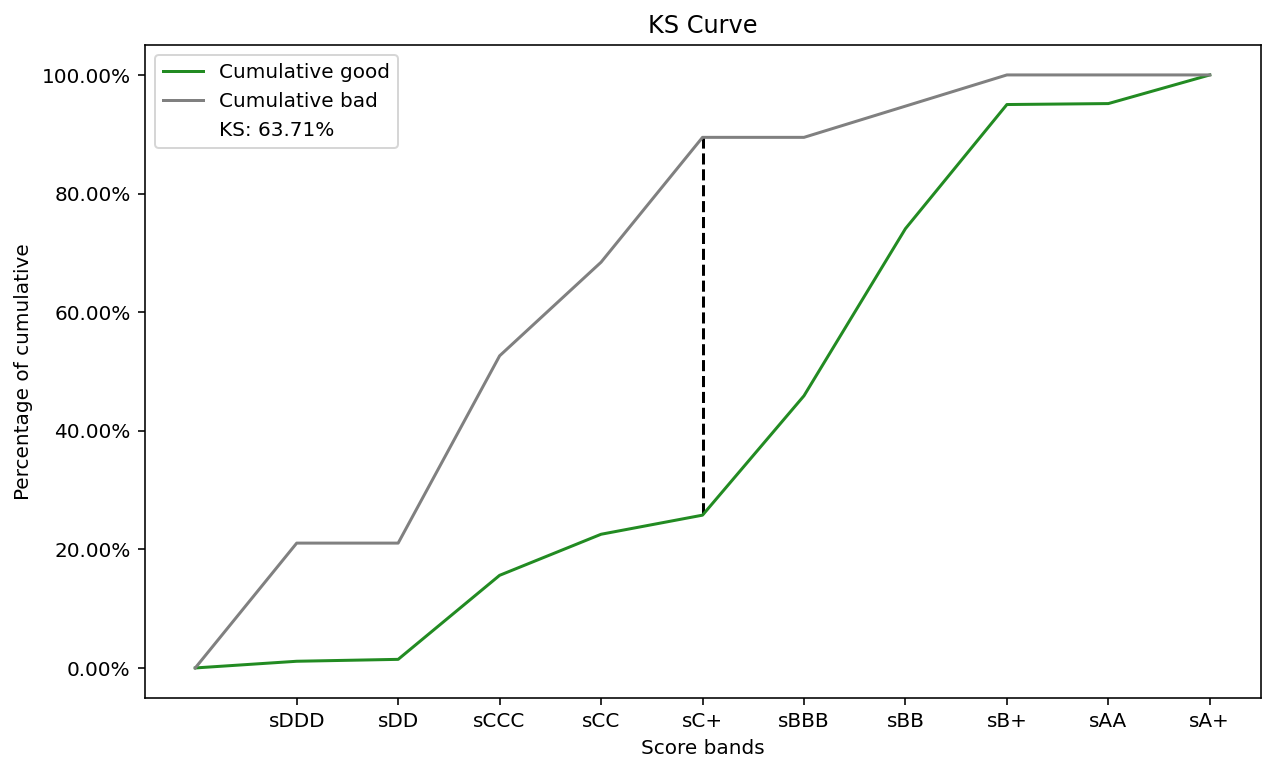

In [64]:
sCRR = KS_index(df_sCRR)
plot_KS(sCRR)